## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Save to output_images/calibration
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imwrite('output_images/calibration/img_' + os.path.split(fname)[1], img)

## Distortion correction

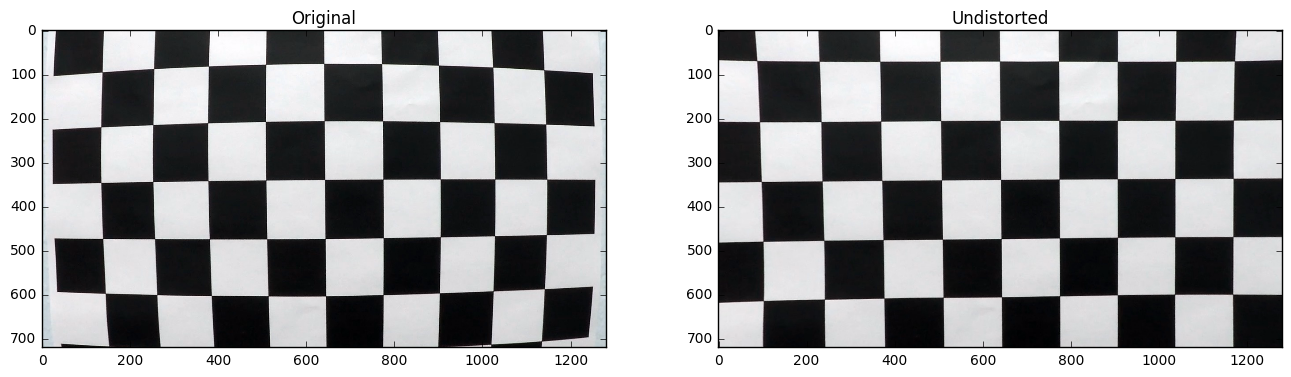

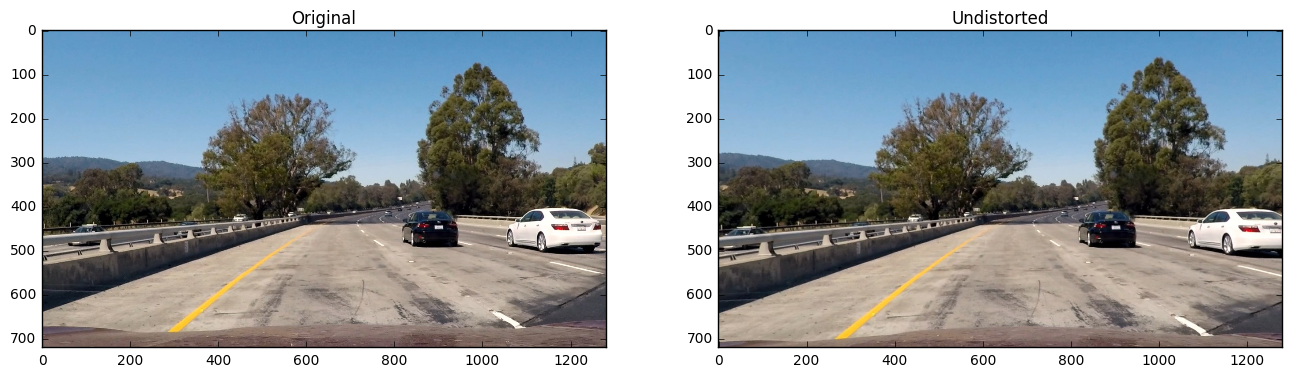

In [91]:
img = cv2.imread('camera_cal/calibration1.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
%matplotlib inline
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

undist = undistort(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 9))
ax1.set_title('Original')
ax1.imshow(img)
ax2.set_title('Undistorted')
ax2.imshow(undist)
plt.show()

img = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
undist = undistort(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 9))
ax1.set_title('Original')
ax1.imshow(img)
ax2.set_title('Undistorted')
ax2.imshow(undist)
plt.show()

In [3]:
for fname in images:
    img = cv2.imread(fname)
    
    # Save to output_images/undistorted
    undist = undistort(img)
    cv2.imwrite('output_images/undistorted/undist_' + os.path.split(fname)[1], undist)

Helper functions

In [77]:
def pipeline(img,orient='x',kernel=5,r_thresh=(250,255),sobel_thresh=(30,255)):
    r = img[:, :, 0]
    sobel = cv2.Sobel(r,cv2.CV_64F,1,0,ksize=kernel) if orient=='x' else cv2.Sobel(r,cv2.CV_64F,0,1,ksize=kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Equalize histogram
    r_channel = cv2.equalizeHist(r)
    
    # Threshold x gradient
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold r channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
        
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (r_binary == 1)] = 1
    vertices = np.array([[(100, img.shape[0]), (620, 420), (750, 450), (1200, img.shape[0])]], dtype = np.int32)
    roi_binary = region_of_interest(combined_binary, vertices)
    return combined_binary, roi_binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by the "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Color/gradient threshold

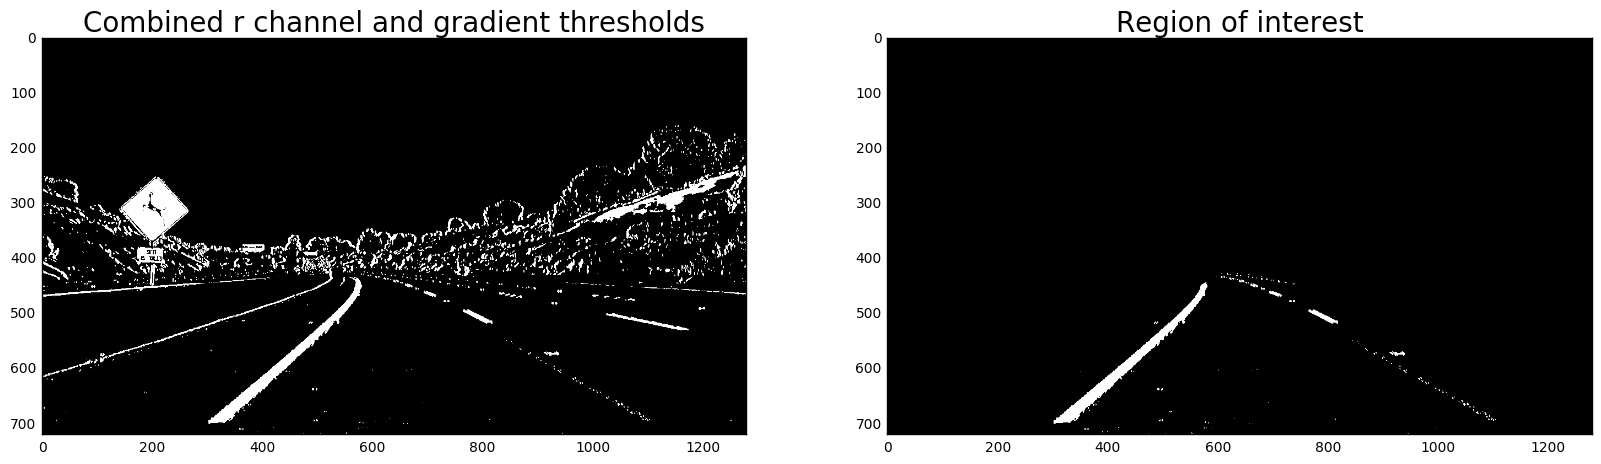

In [120]:
import matplotlib.image as mpimg
img = mpimg.imread('test_images/test2.jpg')
undist = undistort(img)
combined_binary, roi_binary = pipeline(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.set_title('Combined r channel and gradient thresholds', fontsize = 20)
ax1.imshow(combined_binary, cmap = 'gray')
ax2.set_title('Region of interest', fontsize = 20)
ax2.imshow(roi_binary, cmap = 'gray')
plt.show()

## Perspective transform

In [100]:
def warper(img, src, dst):
    
    # Compute and apply perspective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

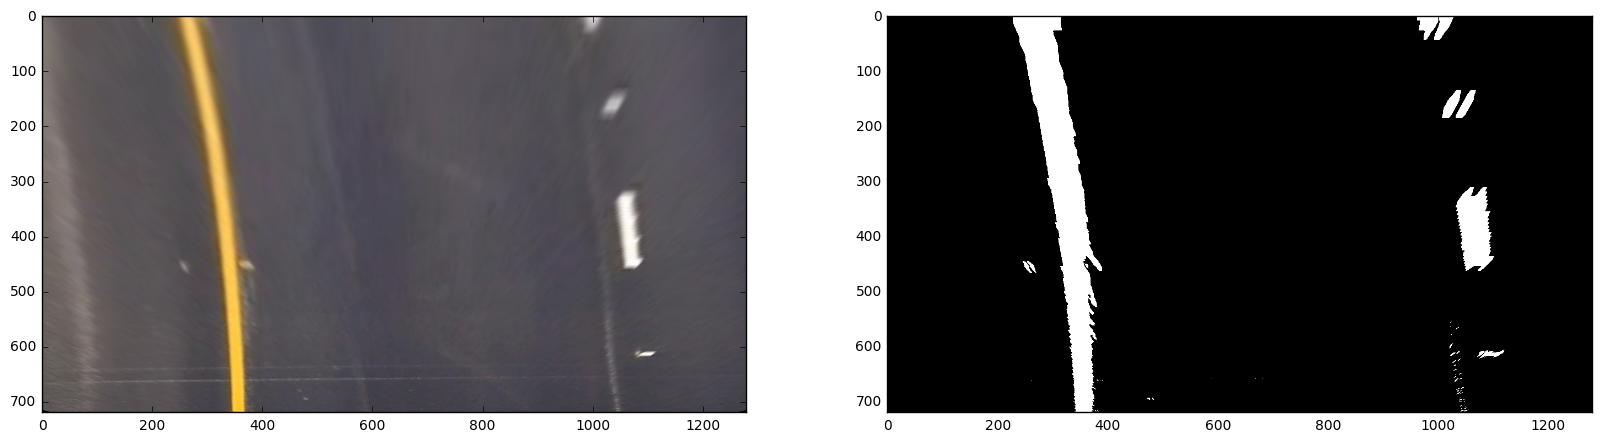

In [121]:
undist = undistort(img)
src = np.float32([[570, 468], [270, 670], [1010, 670], [710, 468]])
dst = np.float32([[280, 0], [280, 720], [1000, 720], [1000, 0]])
undist_warped = warper(undist, src, dst)
binary_warped = warper(roi_binary, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(undist_warped)
ax2.imshow(binary_warped, cmap = 'gray')

for fname in glob.glob('test_images/test*.jpg'):
    img = cv2.imread(fname)
    
    # Save to output_images/transformed
    undist = undistort(img)
    transformed = warper(undist, src, dst)
    cv2.imwrite('output_images/transformed/trans_' + os.path.split(fname)[1], transformed)

## Detect lane lines

In [83]:
def processing(image):
    undist = undistort(image)
    transformed = warper(undist, src, dst)
    binary_warped, _ = pipeline(transformed)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Identify nonzero pixels
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # Set the width of windows
    margin = 100
    global left_fit, right_fit
    if left_fit is None:
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)
        leftx_current = leftx_base
        rightx_current = rightx_base
        minpix = 50
        left_lane_inds = []
        right_lane_inds = []
        
        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > minpix:
                left_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                right_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]-margin))&
                          (nonzerox < (left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]+margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]-margin))&
                           (nonzerox < (right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]+margin)))
        # Extract pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx =right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    window_img = np.zeros_like(out_img)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(window_img, np.int_([pts]), (0, 255, 0))
    
    newwarp = warper(window_img, dst, src)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Determine the curvature of the lane
    radius = curvature(ploty, left_fitx, right_fitx)
    position = offset(result, ploty, left_fit, right_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature = %d (m)'%radius,(430, 630),font,1,(0,0,255),2,cv2.LINE_AA)
    if position < 0:
        cv2.putText(result,'Vehicle is %.3fm  left of center'%-position,(430,670),font,1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(result,'Vehicle is %.3fm right of center'%position,(430,670),font,1,(255,255,255),2,cv2.LINE_AA)
    return result

## Determine the lane curvature

In [84]:
def curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    ym_per_mix = 20/720
    xm_per_mix = 3.7/700
    left_fit_cr = np.polyfit(ploty*ym_per_mix, left_fitx*xm_per_mix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_mix, right_fitx*xm_per_mix, 2)
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval*ym_per_mix+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval*ym_per_mix+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    radius = np.mean((left_curverad, right_curverad))
    return radius

def offset(img, ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    xm_per_mix = 3.7/700
    left_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    position = (img.shape[1]/2 - np.mean((left_eval, right_eval)))*xm_per_mix
    return position

## Test images

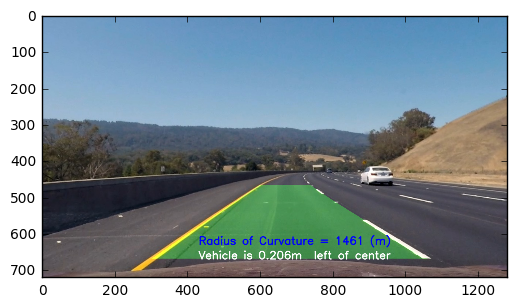

In [85]:
import matplotlib.image as mpimg
img = mpimg.imread('test_images/test3.jpg')
left_fit, right_fit, left_ref, right_ref = None, None, [], []
result = processing(img)
plt.imshow(result)

## Video

In [86]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'out_project_video.mp4'
clip = VideoFileClip('project_video.mp4')
left_fit, right_fit, left_ref, right_ref = None, None, [], []
project_clip = clip.fl_image(processing)
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [02:51<00:00,  5.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 2min 55s, sys: 3.34 s, total: 2min 58s
Wall time: 2min 53s
